Заболеваемость и смертность от сердечно-сосудистых заболеваний (ССЗ) продолжает расти во всем мире на протяжении последних нескольких десятилетий. Машинное обучение дает возможность повысить точность прогнозирования рисков сердечно-сосудистых заболеваний.

В этом проекте предстоит изучить статью о применении моделей машинного обучения для предсказания ССЗ, а также обучить собственную модель.

Выбранный датасет содержит 600 000 записей в обучающем наборе и 400 000 в тестовом. Каждая запись содержит id пациента и 13 признаков:

Age (возраст);
Sex (пол);
Resting_blood_pressure (артериальное давление в состоянии покоя);
Serum_cholestoral (уровень холестерина в крови mg/dl);
Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
Exercise_induced_angina (стенокардия при нагрузке),
Oldpeak (депрессия ST-сегмента);
Slope (наклон пикового сегмента ST при физической нагрузке);
Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
Chest_bin (боль в груди от 1 до 4).


In [55]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib  # Для сохранения моделей
import warnings


In [56]:
# 1. Загрузка данных
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Просмотр первых строк для понимания структуры данных
train_data.head(), train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

(   ID        age  sex     chest  resting_blood_pressure  serum_cholestoral  \
 0   0  49.207124    0  4.000000              162.996167         181.108682   
 1   1  53.628425    1  1.741596              130.233730         276.474630   
 2   2  49.591426    1  4.000000              146.999012         223.300517   
 3   3  58.991445    1  4.000000              112.369143         187.245501   
 4   4  51.053602    1  1.954609              138.032047         238.482868   
 
    fasting_blood_sugar  resting_electrocardiographic_results  \
 0                    0                                     0   
 1                    0                                     2   
 2                    1                                     2   
 3                    0                                     0   
 4                    0                                     0   
 
    maximum_heart_rate_achieved  exercise_induced_angina   oldpeak  slope  \
 0                   148.227858                        

Данные содержат 600,000 строк и 15 столбцов, среди которых:

Числовые столбцы, такие как возраст, уровень холестерина и давление, представлены в виде float или int.
Категориальные переменные (например, пол, результат электрокардиографии, наличие стенокардии) представлены в виде числовых кодов.
Целевой столбец — class.

In [57]:
# 2. Проверки и фильтрация некорректных значений
# Проверка на пропущенные значения
print("Пропущенные значения в тренировочных данных:\n", train_data.isnull().sum())
print("Пропущенные значения в тестовых данных:\n", test_data.isnull().sum())

# Если есть пропущенные значения, можно выбрать стратегию их обработки
# Например, удаление строк с пропущенными значениями
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Проверка на некорректные значения (например, отрицательные значения для возраста)
# Фильтруем записи с некорректными значениями
train_data = train_data[(train_data['age'] > 0) & (train_data['serum_cholestoral'] >= 0) & (train_data['resting_blood_pressure'] >= 0)]
test_data = test_data[(test_data['age'] > 0) & (test_data['serum_cholestoral'] >= 0) & (test_data['resting_blood_pressure'] >= 0)]


Пропущенные значения в тренировочных данных:
 ID                                      0
age                                     0
sex                                     0
chest                                   0
resting_blood_pressure                  0
serum_cholestoral                       0
fasting_blood_sugar                     0
resting_electrocardiographic_results    0
maximum_heart_rate_achieved             0
exercise_induced_angina                 0
oldpeak                                 0
slope                                   0
number_of_major_vessels                 0
thal                                    0
class                                   0
dtype: int64
Пропущенные значения в тестовых данных:
 ID                                      0
age                                     0
sex                                     0
chest                                   0
resting_blood_pressure                  0
serum_cholestoral                       0
fasting_blood_suga

In [58]:
# 3. Предобработка данных
cat_list = ['sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 
            'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

for elem in cat_list:
    train_data[elem] = train_data[elem].astype(object)
    test_data[elem] = test_data[elem].astype(object)

# Преобразование категориальных переменных в дамми-переменные
df_train_mod = pd.get_dummies(train_data, columns=cat_list, dtype='int', drop_first=True)
df_test_mod = pd.get_dummies(test_data, columns=cat_list, dtype='int', drop_first=True)

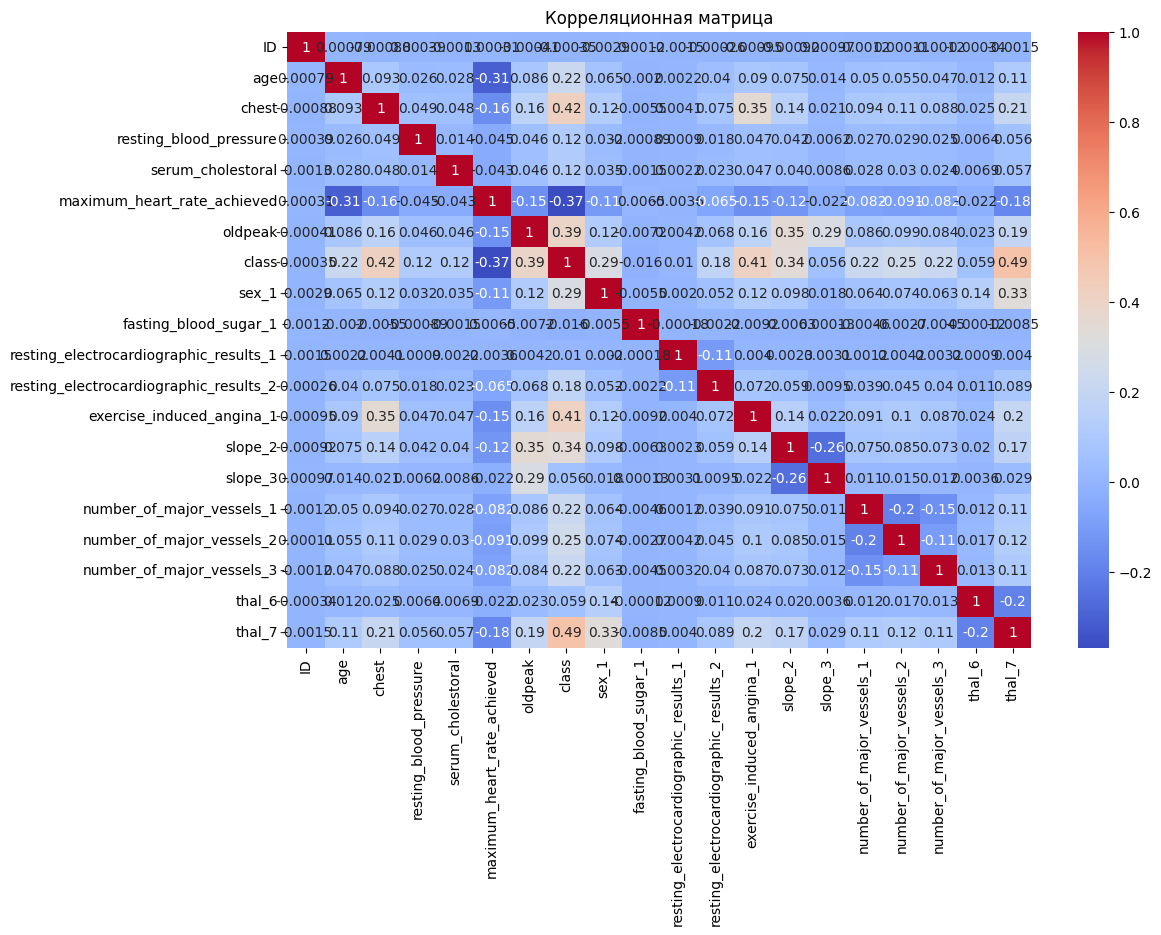

In [59]:
# 4. Корреляционный анализ

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_train_mod.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

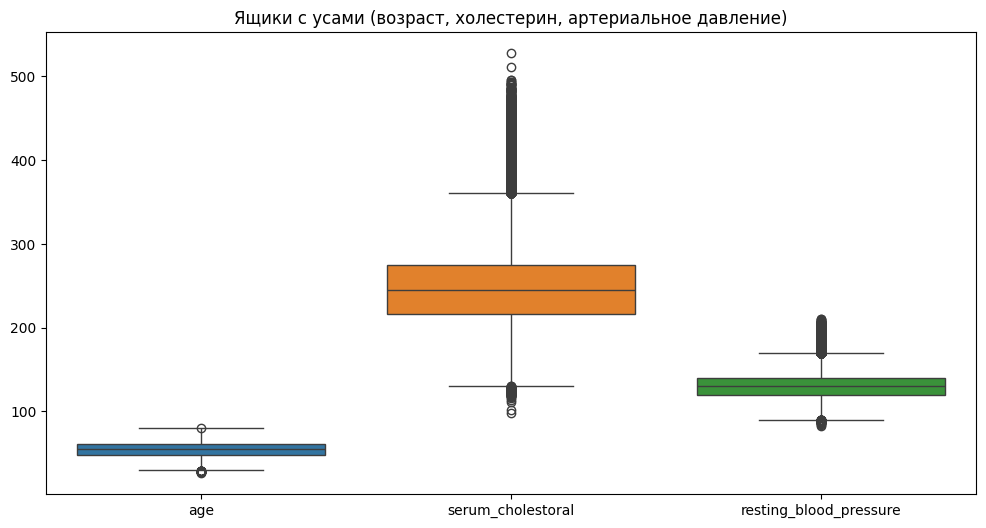

In [60]:
# Ящики с усами
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data[['age', 'serum_cholestoral', 'resting_blood_pressure']])
plt.title('Ящики с усами (возраст, холестерин, артериальное давление)')
plt.show()

In [61]:
# 5. Разделение на признаки и целевую переменную (для тренировочных данных)
X_train = df_train_mod.drop(columns=['class'])  # Замените 'class' на правильное название целевой переменной
y_train = df_train_mod['class']

X_test = df_test_mod  # В тестовых данных целевая переменная отсутствует

In [62]:
# 6. Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
# 7. Обучение моделей

# Логистическая регрессия
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

In [64]:
# Случайный лес
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [65]:
# Глубокая нейронная сеть с ранней остановкой
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42, early_stopping=True)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

In [66]:
# 8. Оценка качества моделей (для тренировочных данных)

# Разделение тренировочных данных на обучение и валидацию
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Логистическая регрессия
log_model.fit(X_train_split, y_train_split)
y_val_pred_log = log_model.predict(X_val_split)
print("Logistic Regression:\n", classification_report(y_val_split, y_val_pred_log))

# Случайный лес
rf_model.fit(X_train_split, y_train_split)
y_val_pred_rf = rf_model.predict(X_val_split)
print("Random Forest:\n", classification_report(y_val_split, y_val_pred_rf))

# Глубокая нейронная сеть
mlp_model.fit(X_train_split, y_train_split)
y_val_pred_mlp = mlp_model.predict(X_val_split)
print("Neural Network:\n", classification_report(y_val_split, y_val_pred_mlp))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     66812
           1       0.88      0.86      0.87     53188

    accuracy                           0.88    120000
   macro avg       0.88      0.88      0.88    120000
weighted avg       0.88      0.88      0.88    120000

Random Forest:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91     66812
           1       0.89      0.88      0.88     53188

    accuracy                           0.90    120000
   macro avg       0.90      0.89      0.90    120000
weighted avg       0.90      0.90      0.90    120000

Neural Network:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     66812
           1       0.89      0.88      0.89     53188

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       

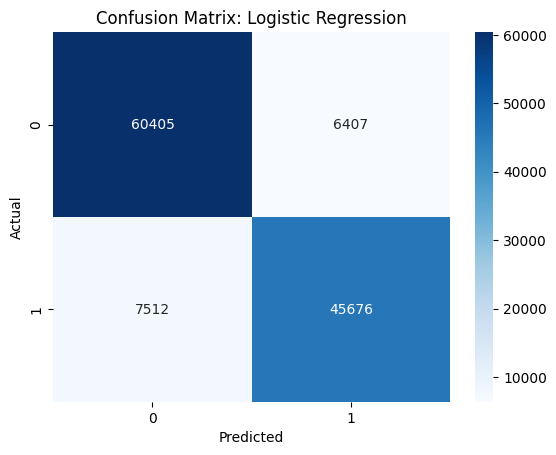

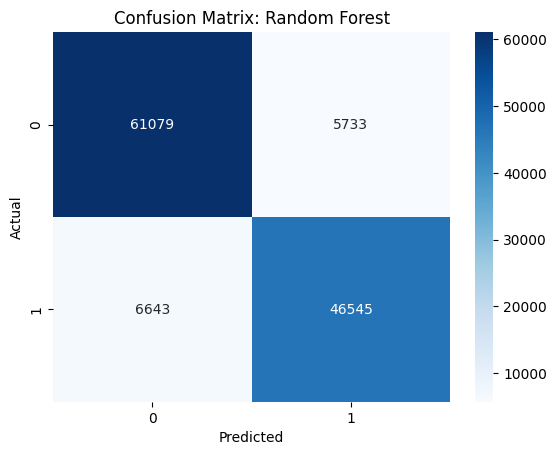

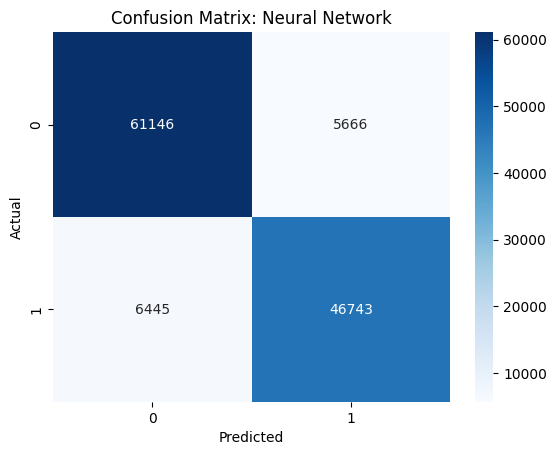

In [67]:
# 9. Матрицы ошибок
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion(y_val_split, y_val_pred_log, 'Logistic Regression')
plot_confusion(y_val_split, y_val_pred_rf, 'Random Forest')
plot_confusion(y_val_split, y_val_pred_mlp, 'Neural Network')

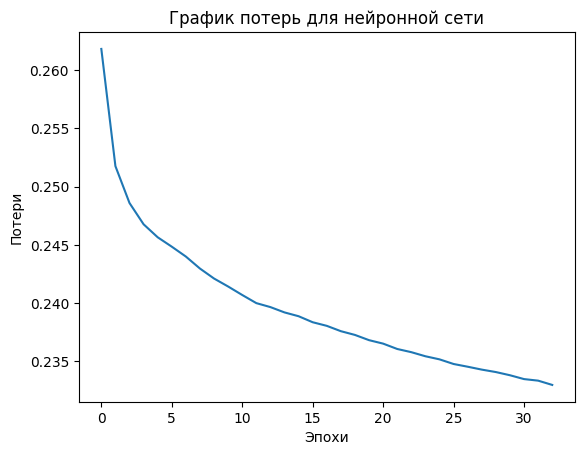

In [68]:
# 10. Графики обучения (AUC и потери для нейронной сети)
train_loss = mlp_model.loss_curve_
plt.plot(train_loss)
plt.title('График потерь для нейронной сети')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

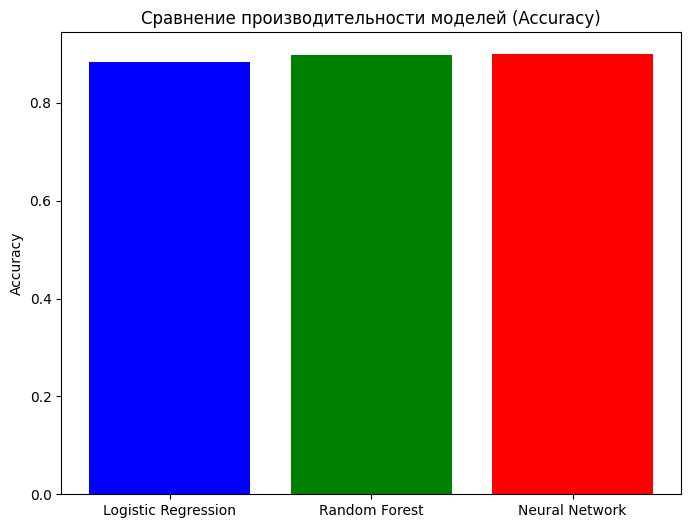

In [69]:
# 11. Сравнение производительности моделей
models = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracies = [accuracy_score(y_val_split, y_val_pred_log), accuracy_score(y_val_split, y_val_pred_rf), accuracy_score(y_val_split, y_val_pred_mlp)]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Сравнение производительности моделей (Accuracy)')
plt.ylabel('Accuracy')
plt.show()

In [70]:
# 12. Экспорт лучшей модели
best_model = rf_model if max(accuracies) == accuracy_score(y_val_split, y_val_pred_rf) else mlp_model
joblib.dump(best_model, 'best_model.pkl')  # Экспорт лучшей модели в файл

['best_model.pkl']